# Test Implementation of the PARC Metric v2

This version of the notebook streams data instead of downloading it.

See https://github.com/alan-turing-institute/ARC-LoCoMoSeT/issues/6

Notebook will be split into two sections for sanity's sake:

1. Methods for extracting the relevant feature information from models and data from Hugging Face
2. The implementation of the PARC metric.

In [9]:
from typing import Callable

import numpy as np
np.set_printoptions(edgeitems=30, linewidth=180)

from copy import copy
from scipy.stats import spearmanr
import requests
import torch
from datasets import Dataset, load_dataset
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from transformers import AutoImageProcessor, AutoModelForImageClassification

## Get Model

First step is to load the models, let's try something different from what Jack tried in the Renngli et al. notebook for varieties sake.

Model selection: Google's vit-base-patch16-224,  https://huggingface.co/google/vit-base-patch16-224

In [3]:
model_name = 'google/vit-base-patch16-224'

model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=0)
print(model)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [4]:
processor = AutoImageProcessor.from_pretrained(model_name)
print(processor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



## Sample Image

Lets have a look at some sample images and what we can do with them, from the COCO dataset.

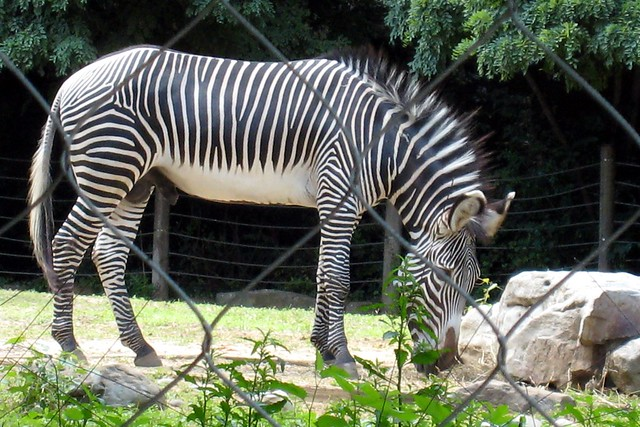

In [5]:
url = "https://farm2.staticflickr.com/1126/1097065370_2701501707_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [6]:
# process image for model
inputs = processor(images=image, return_tensors='pt')
outputs = model(**inputs)
logits = outputs.logits

In [7]:
inputs['pixel_values']

tensor([[[[-0.5294, -0.7725, -0.8824,  ..., -0.5529, -0.4588, -0.3569],
          [-0.6157, -0.7804, -0.8510,  ..., -0.2863, -0.2941, -0.4431],
          [-0.5922, -0.8118, -0.8353,  ..., -0.3882, -0.3882, -0.4510],
          ...,
          [ 0.2392, -0.0118,  0.1373,  ..., -0.2784, -0.2392,  0.2235],
          [ 0.0745, -0.0745,  0.2314,  ..., -0.3020, -0.1137,  0.0745],
          [-0.0275,  0.0353,  0.2392,  ..., -0.2941, -0.1765, -0.0824]],

         [[-0.2392, -0.5843, -0.7882,  ..., -0.2863, -0.1529, -0.0039],
          [-0.3725, -0.6157, -0.7725,  ..., -0.0039,  0.0275, -0.0824],
          [-0.3961, -0.6706, -0.7725,  ..., -0.0902, -0.0588, -0.0824],
          ...,
          [ 0.5059,  0.2549,  0.4118,  ...,  0.1529,  0.1451,  0.5294],
          [ 0.3333,  0.2000,  0.4902,  ...,  0.1608,  0.2784,  0.3882],
          [ 0.2157,  0.3098,  0.5059,  ...,  0.2000,  0.2863,  0.3255]],

         [[-0.3804, -0.6784, -0.8353,  ..., -0.5059, -0.4510, -0.4039],
          [-0.4902, -0.7020, -

In [7]:
# model used to predict one of the 100 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print(predicted_class_idx)
print(model.config)
print(f'Predicted class: {model.config.id2label[predicted_class_idx]}')

314
ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {},
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {},
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.30.2"
}



KeyError: 314

Seems to do pretty well at classifying the animal out of the gate.

## Extracting Features from Model

For the transformer architectures we want to extract the model representations directly prior to the classification layer, i.e. the final layers of the feed forward part of the architecture. This will vary depending on the model used, as noted in the relevant issue. In this case - <code> VitForImageClassification</code> - this can be found in <code> model.vit() </code>.

Lets examine the ouptut of the model with the last layer removed on same image.

In [8]:
# print(inputs)
feats = model(inputs['pixel_values'])
feats.logits

tensor([[-6.9822e-01,  2.9850e-01,  1.8177e-01,  3.9206e-01,  8.3252e-01,
         -2.6150e-01, -2.6624e-01,  5.2765e-01, -3.9376e-01,  4.6765e-02,
          2.1858e-01,  1.9420e+00, -8.6332e-01,  1.2162e+00,  6.1439e-01,
          7.2315e-01, -4.1218e-01,  4.8924e-01,  9.6547e-01,  2.5915e-01,
         -5.5239e-01, -2.4958e-01,  1.3608e-01, -1.6574e-01, -1.3343e-01,
          7.1999e-01, -1.8449e-03,  2.5471e-01,  1.1267e-01,  1.0461e-01,
         -8.3902e-01, -7.7280e-01,  4.9698e-01, -4.9504e-01, -1.0042e+00,
         -3.3588e-01, -4.1874e-01, -2.7376e-01,  3.2876e-01,  4.3063e-01,
          2.2409e+00,  1.1892e-01,  9.9479e-02, -6.6571e-01,  6.5259e-01,
          8.6768e-01, -2.8116e-01,  4.7230e-01, -7.9194e-02, -4.7614e-01,
          3.6232e-01, -7.5189e-01,  7.4721e-01,  1.5689e+00,  1.0140e+00,
          1.6068e+00,  1.0329e+00, -5.1893e-01, -5.0331e-02, -8.8196e-01,
          2.3411e-01,  2.0231e+00,  6.8360e-02,  2.8975e-01, -1.2423e+00,
          5.9400e-02, -1.8129e-01,  4.

NB: not a flat representations, has shape:

In [9]:
feats.logits

tensor([[-6.9822e-01,  2.9850e-01,  1.8177e-01,  3.9206e-01,  8.3252e-01,
         -2.6150e-01, -2.6624e-01,  5.2765e-01, -3.9376e-01,  4.6765e-02,
          2.1858e-01,  1.9420e+00, -8.6332e-01,  1.2162e+00,  6.1439e-01,
          7.2315e-01, -4.1218e-01,  4.8924e-01,  9.6547e-01,  2.5915e-01,
         -5.5239e-01, -2.4958e-01,  1.3608e-01, -1.6574e-01, -1.3343e-01,
          7.1999e-01, -1.8449e-03,  2.5471e-01,  1.1267e-01,  1.0461e-01,
         -8.3902e-01, -7.7280e-01,  4.9698e-01, -4.9504e-01, -1.0042e+00,
         -3.3588e-01, -4.1874e-01, -2.7376e-01,  3.2876e-01,  4.3063e-01,
          2.2409e+00,  1.1892e-01,  9.9479e-02, -6.6571e-01,  6.5259e-01,
          8.6768e-01, -2.8116e-01,  4.7230e-01, -7.9194e-02, -4.7614e-01,
          3.6232e-01, -7.5189e-01,  7.4721e-01,  1.5689e+00,  1.0140e+00,
          1.6068e+00,  1.0329e+00, -5.1893e-01, -5.0331e-02, -8.8196e-01,
          2.3411e-01,  2.0231e+00,  6.8360e-02,  2.8975e-01, -1.2423e+00,
          5.9400e-02, -1.8129e-01,  4.

The multi attention heads are passed positional encodings for all the patches, prepended with a special classifier token. This classifier token is then taken from the output and passed through the FFWD net before classification. In the ViT paper (https://arxiv.org/pdf/2010.11929.pdf) this is referred to as standard, but what is the intuition behind this method? (Attention should give the token everything it needs for classification + efficient to throw away the rest + unbiased as a token if it starts as null compared to the rest?)

Regardless, it means we must remove the first row only of the features to extract the post-attention:

In [10]:
feats = feats.logits[0]
print(f'features shapes: {feats.shape}')
feats


features shapes: torch.Size([768])


tensor([-6.9822e-01,  2.9850e-01,  1.8177e-01,  3.9206e-01,  8.3252e-01,
        -2.6150e-01, -2.6624e-01,  5.2765e-01, -3.9376e-01,  4.6765e-02,
         2.1858e-01,  1.9420e+00, -8.6332e-01,  1.2162e+00,  6.1439e-01,
         7.2315e-01, -4.1218e-01,  4.8924e-01,  9.6547e-01,  2.5915e-01,
        -5.5239e-01, -2.4958e-01,  1.3608e-01, -1.6574e-01, -1.3343e-01,
         7.1999e-01, -1.8449e-03,  2.5471e-01,  1.1267e-01,  1.0461e-01,
        -8.3902e-01, -7.7280e-01,  4.9698e-01, -4.9504e-01, -1.0042e+00,
        -3.3588e-01, -4.1874e-01, -2.7376e-01,  3.2876e-01,  4.3063e-01,
         2.2409e+00,  1.1892e-01,  9.9479e-02, -6.6571e-01,  6.5259e-01,
         8.6768e-01, -2.8116e-01,  4.7230e-01, -7.9194e-02, -4.7614e-01,
         3.6232e-01, -7.5189e-01,  7.4721e-01,  1.5689e+00,  1.0140e+00,
         1.6068e+00,  1.0329e+00, -5.1893e-01, -5.0331e-02, -8.8196e-01,
         2.3411e-01,  2.0231e+00,  6.8360e-02,  2.8975e-01, -1.2423e+00,
         5.9400e-02, -1.8129e-01,  4.5879e-01, -1.1

In contrast to this certain architectures use pooling (among other CNN techniques) in the final stages. 

(This could be hard to generalise for in the code, but not impossible to pick out from the architecture)

## ImageNet

All the models we've picked are pretrained on ImageNet (possibly hard to find one that isn't at this point), so what does the validation look like for a subset of ImageNet of 1000 images?

Here I'm also streaming the data as the download wasn't working as expected unfortunately. This requires a slight adaptation to a few thing.

NB: (Huggingface note) to use imagenet-1k requires an Authtoken as it's a gated dataset.

In [11]:
dataset = load_dataset(
    'imagenet-1k', split='validation', use_auth_token=True, streaming=True
    )

In [12]:
# Useful function for extracting examples from an iterable:
def iter_extr(iterable, idx_c=0):
    for idx, iter in enumerate(iterable):
        if idx == idx_c:
            return iter

In [13]:
iter_extr(dataset, 1)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'label': 171}

dataset type when streaming is iterable: <class 'datasets.iterable_dataset.IterableDataset'>


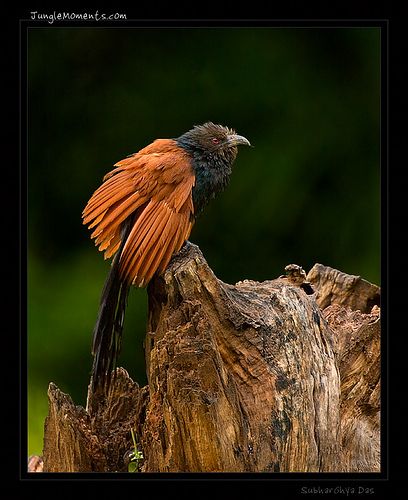

In [14]:
# Have a look at some details of the iterable
print(f'dataset type when streaming is iterable: {type(dataset)}')
display(iter_extr(dataset, 0)['image'])

## Preprocess

The data requires some preprocessing before it can be extracted by the model. It's a mess. Notes from Jack's Renggli notebook:

1. Images not always encoded RGB, may have alpha channel or be greyscale etc., some of which the preprocessor are not happy with. So need to convert first.
2. preprocessor seems unhappy with receiving a LazyBatch as input (as provided by dataset.map) so need to include that in the RGB conversion loop as well rather than passing it the whole batch at one.
3. But combination of preprocessor in a loop and .map somehow ends up returning a list of lists rather than np.array / torch.tensor, so convert it to torch.tensor afterwards...

Further to this there are some subtleties required when preprocessing the streaming data.

In [15]:
def preprocess(examples):
    examples['pixel_values'] = [
        processor(image.convert('RGB'))['pixel_values'][0]
        for image in examples['image']
    ]
    return examples

imgs = dataset.map(preprocess, remove_columns='image', batched=True, batch_size=1)
imgs = imgs.with_format('torch') 


In [16]:
print(f'imgs should still be an iterable: {type(imgs)}')

imgs should still be an iterable: <class 'datasets.iterable_dataset.IterableDataset'>


In [17]:
print(f'imgs features: {iter_extr(imgs).keys()}')

imgs features: dict_keys(['label', 'pixel_values'])


## Get Features from model with data

For PARC we want to compare the features for single images, so the iterable data set should work just fine.

In [36]:
# Having a look at the features for a single example
inputs = iter_extr(imgs)['pixel_values']

# Have to add back in the extra dimension since we're not batching for PARC
model.vit(inputs[None, :, :, :])    

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.2095, -0.1793,  0.6840,  ..., -0.4790,  0.9457, -1.4258],
         [-0.3067, -0.6432,  0.6874,  ..., -0.3820,  1.7180, -0.7821],
         [-0.2302, -0.5067,  1.0357,  ..., -0.2504,  1.4019, -0.9665],
         ...,
         [-0.3425, -1.1281,  0.8790,  ...,  0.0938,  1.6207, -0.0838],
         [-0.4493, -1.0763,  0.6279,  ...,  0.0846,  1.6215,  0.0291],
         [-0.2408, -0.7012,  0.0349,  ..., -0.2991,  1.6504, -0.3934]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)

In [37]:
# Extracting just the features we need in right dimensions
feats = model.vit(iter_extr(imgs)['pixel_values'][None, :, :, :])
print(f'feats original shape: {feats.to_tuple()[0].shape}')
feats.to_tuple()[0][:, 0, :]

feats original shape: torch.Size([1, 197, 768])


tensor([[-2.0955e-01, -1.7934e-01,  6.8400e-01, -5.1751e-01, -1.3333e+00,
          3.8092e-01, -1.0818e+00,  1.8845e-01, -9.9801e-01, -1.0212e-02,
         -2.6711e-01,  1.0839e+00,  1.3619e+00, -5.7089e-02,  1.3110e-02,
          2.4124e-01,  1.6392e-01, -2.1566e-01,  5.0740e-01,  1.6421e+00,
         -5.8426e-01,  1.6186e+00,  1.2816e+00, -1.2749e+00, -4.3522e-01,
         -9.7474e-01,  6.4590e-01, -3.9170e-01, -3.9663e-01, -9.4166e-01,
         -2.2111e-02,  8.2703e-01, -1.9563e-02,  1.9177e-02, -3.3390e-01,
         -3.0926e-01,  3.0671e-01,  7.4761e-01, -2.2005e-01, -1.1672e+00,
         -1.4188e+00, -1.1374e+00, -1.0848e+00,  1.0464e-01,  9.4242e-01,
          3.2549e-01,  7.2269e-01, -1.5057e+00,  2.1468e-01, -1.0154e+00,
         -1.1898e-01,  6.3364e-01, -1.9425e-01, -3.0813e-01, -7.9147e-02,
          5.7870e-01,  3.5728e-01,  2.6440e-01,  8.9039e-01, -2.5191e-01,
          9.0011e-01, -1.4020e+00,  1.2225e-01, -3.7510e-01, -6.4882e-01,
          3.3562e-01, -9.6507e-01, -5.

In [38]:
# Testing above method for more examples:
for idx, iter in enumerate(imgs):
    feats = model.vit(iter['pixel_values'][None, :, :, :])
    print(f'idx: {idx} feats shape: {feats.to_tuple()[0][:, 0, :].shape}')
    if idx == 10:
        break

idx: 0 feats shape: torch.Size([1, 768])
idx: 1 feats shape: torch.Size([1, 768])
idx: 2 feats shape: torch.Size([1, 768])
idx: 3 feats shape: torch.Size([1, 768])
idx: 4 feats shape: torch.Size([1, 768])
idx: 5 feats shape: torch.Size([1, 768])
idx: 6 feats shape: torch.Size([1, 768])
idx: 7 feats shape: torch.Size([1, 768])
idx: 8 feats shape: torch.Size([1, 768])
idx: 9 feats shape: torch.Size([1, 768])
idx: 10 feats shape: torch.Size([1, 768])


In [47]:
# Combine above into function to extract features
def feat_extraction(
    dataset: Dataset,
    model_fn: Callable = model,
    num_labels: int = 1000,
    num_images: int = 500
):
    """
    Extracts the features and labels into np arrays ready for the PARC metric
    
    Args:
        dataset (Dataset): iterable data set
        model (Callable): classifications model
        num_labels (int): number of class labels, necessary for the 1-hot vectors
        num_images (int): number of images in the dataset to consider
    
    Returns:
        feats (np.array): array of features, held in rows for each image
        labels (np.array): array of labels, each row a 1-hot vector
    """
    def pull_feats(data_iter):
        # Function for pulling the features out of the model
        return model_fn(
            data_iter['pixel_values'][None, :, :, :]
            ).logits
    
    def one_hot_label(data_iter):
        # Function for converting labels to one hot vectors
        vec = np.zeros(num_labels)
        vec[data_iter['label']] = 1.
        return vec
    
    feats = []
    one_hots = []
    for idx, iter in enumerate(dataset):
        feats.append(
            pull_feats(iter).detach().numpy()[0]
        )
        one_hots.append(
            one_hot_label(iter)
        )
        if idx == num_images-1:
            break
        
    return np.asarray(feats), np.asarray(one_hots)    

In [48]:
# Testing above function for first few images:
feats, labels = feat_extraction(imgs, model, num_images=10)
print(f'feats shape: {feats.shape}')
print(feats)
print(f'labels shape: {labels.shape}')
print(labels)

feats shape: (10, 768)
[[-0.20954667 -0.17934085  0.68400156 -0.5175085  -1.3333497   0.38091958 -1.0818235   0.18845364 -0.9980138  -0.01021201 -0.26711005  1.0839051   1.3618687  -0.05708934
   0.01311037  0.24124384  0.16391909 -0.21565573  0.50740093  1.6420572  -0.5842632   1.6185927   1.2815971  -1.2749417  -0.43522018 -0.97473794  0.64589953 -0.39170015
  -0.39663267 -0.94165957 ... -0.86437833 -1.2130333  -0.4837626  -1.9823679   0.7493328  -0.36309138 -1.4825753   0.49265864  1.211474    0.44717082  1.2670964   0.05895324
  -1.4828756  -0.11732868 -0.41129228 -0.26614532  0.6975481  -0.3344917  -0.0493893  -0.9651525  -1.151603    0.05510299 -0.22353238 -0.5617605  -0.11370856  0.6597339
  -0.19353874 -0.47897688  0.9456508  -1.4257864 ]
 [ 1.5439421   0.48542225 -0.00498208  1.4394857   2.2560005  -1.923677   -0.47903872  0.5351016  -1.9102358  -0.9194047   1.2847892  -0.5611326   2.1511912   0.01610448
   0.35690778 -0.08299791  1.4932004  -1.5403054   0.13029045 -0.2567298 

## PARC Implementation

From an implementation perspective PARC is relatively simple to implement, possible to rely on in built numpy functions once the features are extracted. The pipeline is generally as follows:

1. Extract features of model for all images into array, similarly create array of 1-hot vectors for labels.
2. Apply numpys corrcoef method to compute Pearson's product-moment correlation between features of each pair of images and labels.
3. Finally spearman's rank of unique image and label comparison values.

PARC should work on a low number of images.

First testing individual parts:

In [49]:
feats, labels = feat_extraction(imgs, num_images=10)
print(f'feats shape: {feats.shape}, labels shape: {labels.shape}')

feats shape: (10, 768), labels shape: (10, 1000)


In [ ]:
corr_mat_img = np.corrcoef(feats)
corr_mat_labs = np.corrcoef(labels)
print(
    f'shape of corrcoefs should be (10,10): {corr_mat_img.shape}, {corr_mat_img.shape}'
    )

# dist = 1 - corr_mat to ensure absolute positivity
dist_img = 1 - corr_mat_img
dist_labs = 1 - corr_mat_labs

np.around(copy(dist_labs), 5)     # Rounded for clarity in viewing

shape of corrcoefs should be (10,10): (10, 10), (10, 10)


array([[0.   , 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001],
       [1.001, 0.   , 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001],
       [1.001, 1.001, 0.   , 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001],
       [1.001, 1.001, 1.001, 0.   , 1.001, 1.001, 1.001, 1.001, 1.001, 1.001],
       [1.001, 1.001, 1.001, 1.001, 0.   , 1.001, 1.001, 1.001, 1.001, 1.001],
       [1.001, 1.001, 1.001, 1.001, 1.001, 0.   , 1.001, 1.001, 1.001, 1.001],
       [1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 0.   , 1.001, 1.001, 1.001],
       [1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 0.   , 1.001, 1.001],
       [1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 0.   , 1.001],
       [1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 0.   ]])

In [ ]:
# pull out lower triangular values
def lower_tri_arr(arr):
        n = arr.shape[0]
        return arr[np.triu_indices(n, 1)]

labs_lower_tri = lower_tri_arr(dist_labs)
feats_lower_tri = lower_tri_arr(dist_img)

print(f'the length of the two above arrays should be equal: '
      f'{feats_lower_tri.shape[0]} = {labs_lower_tri.shape[0]}')
labs_lower_tri

the length of the two above arrays should be equal: 45 = 45


array([1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001])

In [ ]:
# Spearman's rank for the two lower triangular matrices forms the final PARC metric
spearmanr(feats_lower_tri, labs_lower_tri)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


SpearmanrResult(correlation=nan, pvalue=nan)

Spearman's rank is not defined if one of the two arrays is constant, which is the case if none of the labels overlap! Thus the sample size of images must be big enough to encompass some over laps? 

In [50]:
def parc(
    features: ArrayLike,
    labels: ArrayLike
) -> float:
    """
    Takes computed features from model for each image in a probe data subset (with 
    features as rows), and associated array of 1-hot vectors of labels, returning the 
    PARC metric for transferability.
    
    Args:
        features (ArrayLike, should be numpy compatible): features from model for each
                                                          image in probe dataset
        labels (ArrayLike, numpy compatible): array of 1-hot vectors of labels
    
    Return:
        PARC score (float): transferability score
    """
    dist_imgs = 1 - np.corrcoef(features)   # 1 - corrcoef to enfore absolute positivity
    dist_labs = 1 - np.corrcoef(labels)
    
    def lower_tri_arr(arr):
        n = arr.shape[0]
        return arr[np.triu_indices(n, 1)]
    
    return spearmanr(
        lower_tri_arr(dist_imgs), lower_tri_arr(dist_labs)
    )[0]*100

In [ ]:
# Testing parc on ImageNet
feats, labels = feat_extraction(imgs, model, num_images=500)
parc(feats, labels)

5.1086377637358815

In [42]:
# Testing parc on ImageNet for 1000 images
feats, labels = feat_extraction(imgs, num_images=1000)
parc(feats, labels)

AttributeError: 'BaseModelOutputWithPooling' object has no attribute 'logits'

In [31]:
# Testing parc on ImageNet for 10,000
feats, labels = feat_extraction(imgs, num_images=10000)
parc(feats, labels)

5.309172443076455

PARC gives a particularly low score for ImageNet, and this continues to be the case when scaled up, could this because of the large number of classes? 

Trying it with half of the validation set to see if this can be ameriolated.

In [161]:
# Testing parc on ImageNet for 25,000
feats, labels = feat_extraction(imgs, num_images=25000)
parc(feats, labels)

5.318289435967333

The above tests suggest that the PARC score will essentially top out after a large enough subset, contingent on the variety of the labels being such that the Spearman Correlation is meaningful. How to quantify this second constraint will take some thinking.

## Oxford Pets

Testing the above work on a new data set

In [51]:
pets = load_dataset('pcuenq/oxford-pets', streaming=True, split='train', use_auth_token=True)

In [52]:
print(f'pets data set should be an iterable: {type(pets)}')

pets data set should be an iterable: <class 'datasets.iterable_dataset.IterableDataset'>


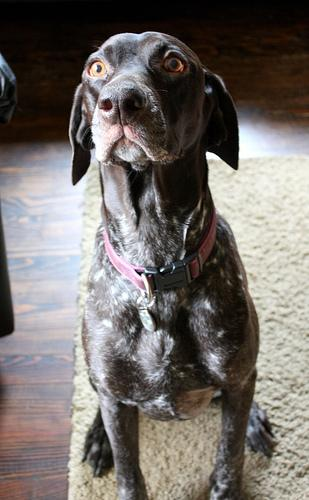

In [53]:
display(iter_extr(pets, 66)['image'])

In [54]:
pets_imgs = (
    pets.map(preprocess, batched=True, remove_columns="image").with_format("torch")
    )

For PARC we want to have the labels as one-hot vectors so wish to adapt the written labels to an index.

In [75]:
pets_labels = ['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British Shorthair',
 'Egyptian Mau',
 'Maine Coon',
 'Persian',
 'Ragdoll',
 'Russian Blue',
 'Siamese',
 'Sphynx',
 'american bulldog',
 'american pit bull terrier',
 'basset hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english cocker spaniel',
 'english setter',
 'german shorthaired',
 'great pyrenees',
 'havanese',
 'japanese chin',
 'keeshond',
 'leonberger',
 'miniature pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint bernard',
 'samoyed',
 'scottish terrier',
 'shiba inu',
 'staffordshire bull terrier',
 'wheaten terrier',
 'yorkshire terrier']

In [76]:
num_labels_pets = len(pets_labels)
num_labels_pets

37

In [77]:
str_to_int = {
    lab: idx for idx, lab in enumerate(pets_labels)
}

In [58]:
str_to_int['scottish terrier']

32

In [78]:
def label_to_int(example):
    example['label'] = str_to_int[example['label']]
    return example

pets_labeled = (
    pets_imgs.map(label_to_int)
)

In [60]:
iter_extr(pets_labeled)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': tensor(10),
 'dog': tensor(False),
 'pixel_values': tensor([[[-0.5765, -0.6235, -0.7020,  ..., -0.8667, -0.9529, -0.9294],
          [-0.5373, -0.5294, -0.5373,  ..., -0.8510, -0.9137, -0.9137],
          [-0.5686, -0.5843, -0.5373,  ..., -0.7647, -0.7412, -0.7569],
          ...,
          [-0.6471, -0.7647, -0.5843,  ..., -0.4196, -0.5216, -0.5373],
          [-0.5294, -0.6706, -0.5529,  ..., -0.5216, -0.4902, -0.4745],
          [-0.6000, -0.5608, -0.4980,  ..., -0.5765, -0.5294, -0.5137]],
 
         [[-0.3020, -0.3490, -0.4353,  ..., -0.7020, -0.8275, -0.8275],
          [-0.2941, -0.2784, -0.2941,  ..., -0.6784, -0.7647, -0.7804],
          [-0.3490, -0.3647, -0.3098,  ..., -0.6000, -0.5843, -0.6078],
          ...,
          [-0.3647, -0.4667, -0.2706,  ..., -0.0196, -0.1216, -0.1294],
          [-0.1765, -0.3176, -0.2000,  ..., -0.1137, -0.0902, -0.0745],
          [-0.2157, -0.1765, -0.1216,  

In [65]:
# Test PARC on it for 500
feats, labels = feat_extraction(pets_labeled, num_images=500, num_labels=num_labels_pets)
parc(feats, labels)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


34.83599881493835

In [66]:
# Test PARC on it for 1000
feats, labels = feat_extraction(pets_labeled, num_images=1000, num_labels=num_labels_pets)
parc(feats, labels)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


34.47722383405635

In [67]:
# Test PARC on it for 10000
feats, labels = feat_extraction(pets_labeled, num_images=10000, num_labels=num_labels_pets)
parc(feats, labels)

33.95617846675583

## PARC with dimensionality reduction

Running metrics based on features will lead to discrepancies from the different number of features present from each model. To over come this PARC can be implemented with feature reduction (dimensionality reduction via PCA):

In [10]:
def feature_reduce(features:np.ndarray, f:int=None) -> np.ndarray:
	"""
	Use PCA to reduce the dimensionality of the features.

	If f is none, return the original features.
	If f < features.shape[0], default f to be the shape.
	"""
	if f is None:
		return features

	if f > features.shape[0]:
		f = features.shape[0]

	return PCA(
		n_components=f,
		svd_solver='randomized',
		random_state=1919,
		iterated_power=1).fit_transform(features)

In [11]:
def parc(
    features: ArrayLike,
    labels: ArrayLike,
    feat_red_dim: int=None
) -> float:
    """
    Takes computed features from model for each image in a probe data subset (with 
    features as rows), and associated array of 1-hot vectors of labels, returning the 
    PARC metric for transferability.
    
    Args:
        features (ArrayLike, should be numpy compatible): features from model for each
                                                          image in probe dataset
        labels (ArrayLike, numpy compatible): array of 1-hot vectors of labels
    
    Return:
        PARC score (float): transferability score
    """
    # 1 - corrcoef to enfore absolute positivity
    dist_imgs = 1 - np.corrcoef(
        feature_reduce(features, feat_red_dim)      # reduce features
        )   
    dist_labs = 1 - np.corrcoef(labels)
    
    def lower_tri_arr(arr):
        n = arr.shape[0]
        return arr[np.triu_indices(n, 1)]
    
    return spearmanr(
        lower_tri_arr(dist_imgs), lower_tri_arr(dist_labs)
    )[0]*100

In [70]:
# Testing parc with feature reduction on pets (f=256):
feats, labels = feat_extraction(pets_labeled, num_images=500, num_labels=num_labels_pets)
parc(feats, labels, 256)

42.53257040901089

In [71]:
# Testing parc with feature reduction on ImageNet (f=256):
feats, labels = feat_extraction(imgs, num_images=500)
parc(feats, labels, 256)

5.14429136234442

## Testing on different models

Lets test PARC on different models for both ImageNet and Pets. Models to test it on:

https://github.com/alan-turing-institute/ARC-LoCoMoSeT/issues/5

General pipline is:

1. Load model and processor
2. Process dataset with specific processor
3. Extract features
4. Compute PARC


Things we wish to test for:

- How does PARC rate these models with/without feature reduction
- How does PARC rate these models with differing size of probe set (seems to be that 500 is enough for it to have settled into a steady state but is this universal?)
- Do we recover roughly what we expect as a ranking based on ImageNet? (Are there other datasets that are common accross the results?)

In [18]:
# Load model
def load_model(
    model_name: str
):
    return (
        AutoModelForImageClassification.from_pretrained(model_name, num_labels=0), 
        AutoImageProcessor.from_pretrained(model_name)
        )

In [19]:
# Load and process data:
def load_and_process_data(
    dataset: str,
    processor: Callable,
    split: str='validation'
):
    dataset = load_dataset(dataset, split=split, use_auth_token=True, streaming=True)
    
    def preprocess(examples):
        examples['pixel_values'] = [
            processor(image.convert('RGB'))['pixel_values'][0]
            for image in examples['image']
        ]
        return examples
    
    imgs = (
        dataset
        .map(preprocess, batched=True, remove_columns='image')
        .with_format("torch")
    )
    
    return imgs
    

In [65]:
# Extract Features
def feat_extraction(
    dataset: Dataset,
    model_fn: Callable,
    num_labels: int = 1000,
    num_images: int = 500
):
    """
    Extracts the features and labels into np arrays ready for the PARC metric
    
    Args:
        dataset (Dataset): iterable data set
        model (Callable): classifications model
        num_labels (int): number of class labels, necessary for the 1-hot vectors
        num_images (int): number of images in the dataset to consider
    
    Returns:
        feats (np.array): array of features, held in rows for each image
        labels (np.array): array of labels, each row a 1-hot vector
    """
    def pull_feats(data_iter):
        # Function for pulling the features out of the model
        return model_fn(
            data_iter['pixel_values'][None, :, :, :]
            ).logits
    
    def one_hot_label(data_iter):
        # Function for converting labels to one hot vectors
        vec = np.zeros(num_labels)
        vec[data_iter['label']] = 1.
        return vec
    
    feats = []
    one_hots = []
    for idx, iter in enumerate(dataset):
        feats.append(
            pull_feats(iter).detach().numpy()[0]
        )
        one_hots.append(
            one_hot_label(iter)
        )
        if idx == num_images-1:
            break
        
    return np.asarray(feats), np.asarray(one_hots) 

Testing params:

num_images_feat_red: {num_images, feat_red}

In [66]:
param_sets = {
    '500_0': {'num_images': 500, 'feat_red': None},
    '1000_0': {'num_images': 1000, 'feat_red': None},
    '10000_0': {'num_images': 10000, 'feat_red': None},
    '500_256': {'num_images': 500, 'feat_red': 266},
    '1000_256': {'num_images': 1000, 'feat_red': 256},
    '10000_256': {'num_images': 10000, 'feat_red': 256},
    '500_127': {'num_images': 500, 'feat_red': 127},
    '1000_127': {'num_images': 1000, 'feat_red': 127},
    '10000_127': {'num_images': 10000, 'feat_red': 127},
    '500_64': {'num_images': 500, 'feat_red': 64},
    '1000_64': {'num_images': 1000, 'feat_red': 64},
    '10000_64': {'num_images': 10000, 'feat_red': 64},
    '500_32': {'num_images': 500, 'feat_red': 32},
    '1000_32': {'num_images': 1000, 'feat_red': 32},
    '10000_32': {'num_images': 10000, 'feat_red': 32}
}

In [67]:
# Actually very innefficient method.... 
# No need to compute the features every time.
def feats_then_parc(
    dataset,
    model_fn,
    num_labels,
    **kwargs
):
    feats, labels = feat_extraction(
        dataset, 
        model_fn, 
        num_labels=num_labels,
        num_images=kwargs['num_images'],
        )
    return parc(feats, labels, feat_red_dim=kwargs['feat_red'])

### BEiT

https://huggingface.co/microsoft/beit-large-patch16-512

In [21]:
# Load the model
beit_fn, beit_proc = load_model('microsoft/beit-large-patch16-512')

Some weights of the model checkpoint at microsoft/beit-large-patch16-512 were not used when initializing BeitForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BeitForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [22]:
# load ImageNet
img_net = load_and_process_data(
    'imagenet-1k', 
    processor=beit_proc, 
    split='validation'
    )

In [29]:
img_net_head = img_net.take(512)

In [32]:
next(iter(img_net_head))

{'label': tensor(91),
 'pixel_values': tensor([[[-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9922, -0.9922, -0.9843]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000]],
 
         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, 

In [40]:
def get_features(image):
    return beit_fn(image['pixel_values'][None, :, : ,:])

In [39]:
beit_fn(next(iter(img_net_head))['pixel_values'][None, :, :, :])['logits']

tensor([[ 0.1337, -0.7469, -0.0723,  ...,  0.7512,  0.8535, -0.3324]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
def get_features(dataset):
    def feats

In [43]:
next(iter(img_net_head.map(
    lambda image: beit_fn(image['pixel_values'])['logits'], 
    batched=True, 
    batch_size=16,
    remove_columns=['pixel_values', 'label']
)))

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


{'label': tensor(91),
 'pixel_values': tensor([[[-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9922, -0.9922, -0.9843]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000]],
 
         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, 

In [77]:
# Pull features
feats, labels = feat_extraction(img_net, beit_fn, num_images=500)

In [79]:
# PARC test
parc(feats, labels)

5.223142134907373

In [80]:
# PARC test feature reduction 256
parc(feats, labels, feat_red_dim=256)

5.216674236219759

In [82]:
# load Pets
pets_imgs = load_and_process_data(
    'pcuenq/oxford-pets',
    processor=beit_proc,
    split='train'
)

# pets needs the labels to be converted to integers
pets_labeled = (
    pets_imgs.map(label_to_int)
)

In [83]:
# pull features the compute PARC
feats_then_parc(
    pets_labeled,
    beit_fn,
    num_labels=num_labels_pets,
    **param_sets['500_0']
)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


32.08564416426825

In [102]:
# pull features the compute PARC (feat_red=256)
feats_then_parc(
    pets_labeled,
    beit_fn,
    num_labels=num_labels_pets,
    **param_sets['500_256']
)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


47.438424874200244

### Microsoft swin

https://huggingface.co/microsoft/swin-large-patch4-window12-384-in22k

In [63]:
swin_fn, swin_proc = load_model(
    'microsoft/swin-large-patch4-window12-384-in22k'
    )

Some weights of the model checkpoint at microsoft/swin-large-patch4-window12-384-in22k were not used when initializing SwinForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [89]:
# load imagenet
img_net = load_and_process_data(
    'imagenet-1k',
    swin_proc,
    'validation'
)

In [90]:
feats, labels = feat_extraction(img_net, swin_fn)

In [91]:
# PARC
parc(feats, labels)

5.057513359002516

In [92]:
# PARC (f=256)
parc(feats, labels, feat_red_dim=256)

5.114452603396727

In [72]:
feats_then_parc(
    img_net,
    swin_fn,
    **param_sets['500_0'],
    num_labels=1000
)

4.385253291976985

In [73]:
feats_then_parc(
    img_net,
    swin_fn,
    **param_sets['500_256'],
    num_labels=1000
)

5.106864535855415

In [79]:
# load pets
pets_imgs = load_and_process_data(
    'pcuenq/oxford-pets',
    processor=swin_proc,
    split='train'
)

# pets needs the labels to be converted to integers
pets_labeled = (
    pets_imgs.map(label_to_int)
)

In [80]:
# PARC 
feats_then_parc(
    pets_labeled,
    swin_fn,
    num_labels=num_labels_pets,
    **param_sets['500_0']
)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


31.950013528487915

In [81]:
# PARC (f=256)
feats_then_parc(
    pets_labeled,
    swin_fn,
    num_labels=num_labels_pets,
    **param_sets['500_256']
)

35.96633125801045

### Microsoft CvT

https://huggingface.co/microsoft/cvt-13

In [82]:
cvt_fn, cvt_proc = load_model('microsoft/cvt-13')

Some weights of the model checkpoint at microsoft/cvt-13 were not used when initializing CvtForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing CvtForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CvtForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [89]:
# load imagenet
img_net = load_and_process_data(
    'imagenet-1k',
    cvt_proc,
    'validation'
)

In [84]:
feats, labels = feat_extraction(img_net, cvt_fn)

In [85]:
# PARC
parc(feats, labels)

4.80947734224722

In [86]:
# PARC f=256
parc(feats, labels, feat_red_dim=256)

4.957712529267063

In [90]:
feats_then_parc(
    img_net,
    cvt_fn,
    num_labels=1000,
    **param_sets['500_0']
)

4.80947734224722

In [92]:
feats_then_parc(
    img_net,
    cvt_fn,
    num_labels=1000,
    **param_sets['500_256']
)

4.949997959841683

In [93]:
# load pets
pets_imgs = load_and_process_data(
    'pcuenq/oxford-pets',
    processor=cvt_proc,
    split='train'
)

# pets needs the labels to be converted to integers
pets_labeled = (
    pets_imgs.map(label_to_int)
)

In [115]:
feat, labels = feat_extraction(pets_labeled, cvt_fn, num_labels=num_labels_pets)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [94]:
# PARC
feats_then_parc(
    pets_labeled,
    cvt_fn,
    num_labels=num_labels_pets,
    **param_sets['500_0']
)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


21.217739109889

In [95]:
# PARC f=256
feats_then_parc(
    pets_labeled,
    cvt_fn,
    num_labels=num_labels_pets,
    **param_sets['500_256']
)

36.77496981996391

## Testing Various Methods 

In [61]:
def get_features(
    dataset,
    model_fn,
    num_labels
):
    """
        Attempting to get the features and labels as needed for PARC using the .map
        method on the streamed dataset.
    """
    def reshape_data(data):
        data['logits'] = model_fn(data['pixel_values'][None, :, :, :])
        one_hot = np.zeros(num_labels)
        one_hot[data['label']] = 1.
        data['one_hot_label'] = one_hot
        return data
    
    dataset = dataset.map(
        reshape_data,
        remove_columns=['pixel_values', 'label']
    )
    
    logits = []
    labels = []
    for data in dataset:
        logits.append(data['logits'])
        labels.append(data['one_hot_label'])
    
    return np.asarray(logits), np.asarray(labels)

In [ ]:
dataset.cast_column('label', )

## Tests for PARC


Development of various tests to check the PARC metric is working correctly, looking at:

1. What does it look like for perfect features based on the labels?
2. What does it look like for uniform random features?

In [4]:
import numpy as np
import pytest
from sklearn.preprocessing import OneHotEncoder

In [164]:
# First perfect features
def test_parc_perfect_features():
    n_classes = 3
    n_samples = 100
    labels = np.random.randint(0, n_classes, n_samples)
    labs = np.zeros((n_samples, n_classes))
    for iter, item in enumerate(labels):
        labs[iter][item] = 1.
    assert parc(labs, labs) == 100

In [165]:
test_parc_perfect_features()

In [28]:
# now random features
n_classes = 3
n_features = 5
n_samples = 1000

In [29]:
labels = np.random.randint(0, n_classes, n_samples)

In [30]:
labs = np.zeros((n_samples, n_classes))
for iter, item in enumerate(labels):
    labs[iter][item] = 1.

In [31]:
features = np.random.normal(size=(n_samples, n_features))

In [32]:
parc(features, labs)

0.20865907480318818

In [33]:
pytest.approx(0., abs=0.25)

0.0 ± 2.5e-01

In [34]:
assert np.around(parc(features, labs)) == 0.

In [37]:
def test_parc_random_features():
    n_classes = 3
    n_features = 5
    n_samples = 1000
    labels = np.zeros((n_samples, n_classes))
    for itr, itm in enumerate(
        np.random.randint(0, n_classes, n_samples)
    ):
        labels[itr][itm] = 1.
    features = np.random.normal(size=(n_samples, n_features))
    assert parc(features, labels) == pytest.approx(0., abs=0.3)

In [38]:
test_parc_random_features()